In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Cascade Cup/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Cascade Cup/test.csv')
df.head()

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.816667,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.533333,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.350000,NaN


In [ ]:
drop_col = list(set(df.columns) - set(test_df.columns))
drop_col.remove('cancelled')
print(drop_col)
# columns which are in train but not test data
df.drop(columns=drop_col, inplace=True)

['pickup_time', 'cancelled_time', 'delivered_time']


In [ ]:
drop_col = ['reassignment_method', 'reassignment_reason', 'reassigned_order', 'order_id']
df.drop(columns=drop_col, inplace = True)
test_df.drop(columns=drop_col, inplace=True)

In [ ]:
date_cols = ['order_time', 'order_date', 'allot_time', 'accept_time']
for col in date_cols:
  df[col] = pd.to_datetime(df[col])
  test_df[col] = pd.to_datetime(test_df[col])

In [ ]:
for col in date_cols:
  print(df[col].dt.year.unique())
# year needs to be removed only 2021

[2021]
[2021]
[2021]
[2021.   nan]


In [ ]:
for col in date_cols:
  print(df[col].dt.month.unique())
# only two months

[1 2]
[1 2]
[1 2]
[ 1. nan  2.]


In [ ]:
for col in date_cols:
  print(df[col].dt.day.unique())

[26 27 28 29 30 31  1  2  3  4  5  6]
[26 27 28 29 30 31  1  2  3  4  5  6]
[26 27 28 29 30 31  1  2  3  4  5  6]
[26. nan 27. 28. 29. 30. 31.  1.  2.  3.  4.  5.  6.]


In [ ]:
print((df['order_date'].dt.date == df['order_time'].dt.date).all())
print((df['order_date'].dt.time == datetime.time(0,0,0)).all())
# order date has time as 00:00:00 for all cols, it needs to be removed
df.drop(columns='order_date', inplace=True)
test_df.drop(columns='order_date', inplace=True)

True
True


In [ ]:
df.cancelled.value_counts()
# heavily imbalanced dataset

0    444782
1      5218
Name: cancelled, dtype: int64

In [ ]:
df.isna().sum()

order_time                  0
allot_time                  0
accept_time               157
rider_id                    0
first_mile_distance         0
last_mile_distance          0
alloted_orders          16948
delivered_orders        17341
cancelled                   0
undelivered_orders      17341
lifetime_order_count       53
session_time             3675
dtype: int64

In [ ]:
test_df.isna().sum()

order_time                 0
allot_time                 0
accept_time               68
rider_id                   0
first_mile_distance        0
last_mile_distance         0
alloted_orders          4773
delivered_orders        4884
undelivered_orders      4884
lifetime_order_count     778
session_time            5054
dtype: int64

In [ ]:
df['accept_allot_delta'] = (df['accept_time'] - df['allot_time']).dt.seconds
df['allot_order_delta'] = (df['allot_time'] - df['order_time']).dt.seconds

test_df['accept_allot_delta'] = (test_df['accept_time'] - test_df['allot_time']).dt.seconds
test_df['allot_order_delta'] = (test_df['allot_time'] - test_df['order_time']).dt.seconds

df.drop(columns=['accept_time', 'allot_time'], inplace=True)
test_df.drop(columns=['accept_time', 'allot_time'], inplace=True)

In [ ]:
df['weekday'] = df['order_time'].dt.dayofweek.astype('object')
test_df['weekday'] = test_df['order_time'].dt.dayofweek.astype('object')

In [ ]:
df['order_month'] = df['order_time'].dt.month.astype('object')
df['order_hour'] = df['order_time'].dt.hour
df['order_minute'] = df['order_time'].dt.minute
df.drop(columns='order_time', inplace=True)

test_df['order_month'] = test_df['order_time'].dt.month.astype('object')
test_df['order_hour'] = test_df['order_time'].dt.hour
test_df['order_minute'] = test_df['order_time'].dt.minute
test_df.drop(columns='order_time', inplace=True)

In [ ]:
from sklearn.impute import SimpleImputer
imp_cols = ['accept_allot_delta', 'lifetime_order_count', 'session_time']
for col in imp_cols:
  si = SimpleImputer(strategy='median')
  train = np.reshape(np.array(df[col]), newshape=(-1,1))
  test = np.reshape(np.array(test_df[col]), newshape=(-1,1))
  train = np.squeeze(si.fit_transform(train), -1)
  test = np.squeeze(si.transform(test), -1)
  df[col] = train
  test_df[col] = test

In [ ]:
imp_cols = ['alloted_orders', 'delivered_orders', 'undelivered_orders']

In [ ]:
imp_train_x = np.array(df[~df.isna().any(axis=1)].drop(columns=imp_cols+['rider_id', 'cancelled']), dtype=np.float32)
imp_train_y = np.array(df[~df.isna().any(axis=1)][imp_cols], dtype=np.float32)
imp_test_x = np.array(df[df.isna().any(axis=1)].drop(columns=imp_cols+['rider_id', 'cancelled']), dtype=np.float32)

test_imp = np.array(test_df[test_df.isna().any(axis=1)].drop(columns=imp_cols+['rider_id']), dtype=np.float32)

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(imp_train_x, imp_train_y, test_size=0.2, random_state=69)

In [ ]:
from xgboost import XGBRFRegressor
for i, col in enumerate(imp_cols):
  model = XGBRFRegressor()
  print(model.fit(train_x, train_y[:,i]).score(test_x,test_y[:,i]))
  imp_test_y = model.predict(imp_test_x)
  test_pred = model.predict(test_imp)
  idx = df[df.isna().any(axis=1)][imp_cols].index
  test_idx = test_df[test_df.isna().any(axis=1)][imp_cols].index
  df.loc[idx, col] = imp_test_y
  test_df.loc[test_idx, col] = test_pred

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:09:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.29689985392848106
[15:09:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


0.29655598978284026
[15:09:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


0.08047619769277192


In [ ]:
df.isna().sum()
# no more missing values

rider_id                0
first_mile_distance     0
last_mile_distance      0
alloted_orders          0
delivered_orders        0
cancelled               0
undelivered_orders      0
lifetime_order_count    0
session_time            0
accept_allot_delta      0
allot_order_delta       0
weekday                 0
order_month             0
order_hour              0
order_minute            0
dtype: int64

In [ ]:
test_df.isna().sum()

rider_id                0
first_mile_distance     0
last_mile_distance      0
alloted_orders          0
delivered_orders        0
undelivered_orders      0
lifetime_order_count    0
session_time            0
accept_allot_delta      0
allot_order_delta       0
weekday                 0
order_month             0
order_hour              0
order_minute            0
dtype: int64

In [ ]:
cols = ['first_mile_distance', 'last_mile_distance', 'alloted_orders', 'delivered_orders', 'undelivered_orders',
        'lifetime_order_count', 'session_time', 'accept_allot_delta', 'allot_order_delta']

for col in cols:
  x1 = dict(df.groupby('rider_id')[col].mean())
  x2 = dict(df.groupby('rider_id')[col].median())
  x3 = dict(df.groupby('rider_id')[col].min())
  x4 = dict(df.groupby('rider_id')[col].max())
  df[col + '_rider_mean'] = df['rider_id'].apply(lambda x: x1[x])
  df[col + '_rider_median'] = df['rider_id'].apply(lambda x: x2[x])
  df[col + '_rider_min'] = df['rider_id'].apply(lambda x: x3[x])
  df[col + '_rider_max'] = df['rider_id'].apply(lambda x: x4[x])
df.drop(columns='rider_id', inplace=True)

for col in cols:
  x1 = dict(test_df.groupby('rider_id')[col].mean())
  x2 = dict(test_df.groupby('rider_id')[col].median())
  x3 = dict(test_df.groupby('rider_id')[col].min())
  x4 = dict(test_df.groupby('rider_id')[col].max())
  test_df[col + '_rider_mean'] = test_df['rider_id'].apply(lambda x: x1[x])
  test_df[col + '_rider_median'] = test_df['rider_id'].apply(lambda x: x2[x])
  test_df[col + '_rider_min'] = test_df['rider_id'].apply(lambda x: x3[x])
  test_df[col + '_rider_max'] = test_df['rider_id'].apply(lambda x: x4[x])
test_df.drop(columns='rider_id', inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
train_data = ss.fit_transform(df.drop(columns='cancelled'))
train_target = np.array(df['cancelled'])
test_data = ss.transform(test_df)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.35)

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import class_weight
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

base_learner_1 = [
                  ('rf1', XGBClassifier()),
                  ('rf2', RandomForestClassifier()),
                  ('rf3', DecisionTreeClassifier())
]

base_learner_2 = [
                  ('rf1', AdaBoostClassifier()),
                  ('rf2', GaussianNB()),
]

layer_two = StackingClassifier(estimators=base_learner_2, final_estimator=LogisticRegression())
# StackingClassifier(estimators=base_learner_1, final_estimator=layer_two)

model = StackingClassifier(estimators=base_learner_1, final_estimator=layer_two)
model.fit(x_train, y_train, sample_weight=weights).score(x_test, y_test)

0.858679365079365

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, x_test, y_test, n_repeats=2)

In [ ]:
fi = dict(zip(df.drop(columns='cancelled').columns, r.importances_mean))

In [ ]:
fi.pop("undelivered_orders")

0.19659047619047615

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text major ticklabel objects>)

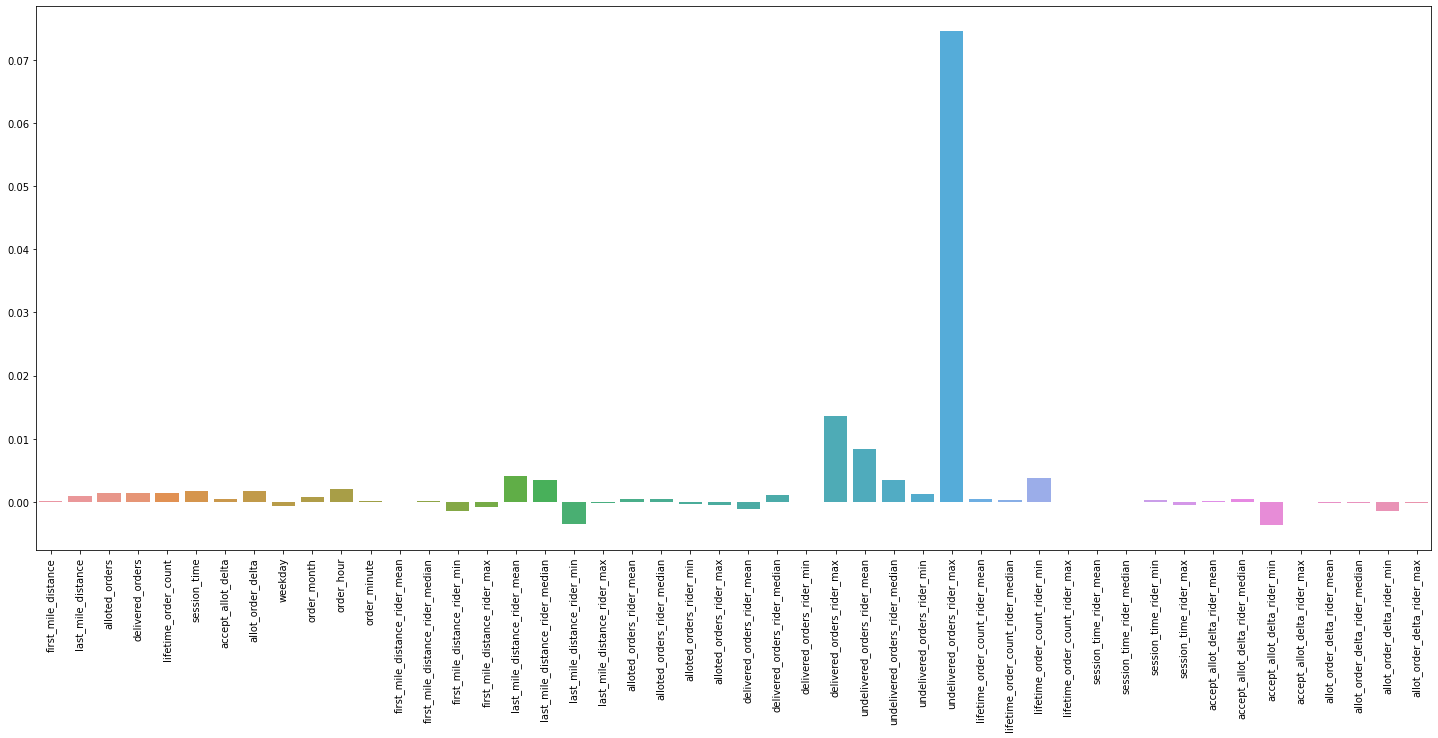

In [ ]:
plt.figure(figsize=(25,10))
sns.barplot(x=list(fi.keys()), y=list(fi.values()))
plt.xticks(rotation=90)

In [ ]:
cols = ['first_mile_distance', 'accept_allot_delta', 'last_mile_distance', 'alloted_orders', 'delivered_orders', 'lifetime_order_count', 'session_time', 'accept_allot_delta', 'allot_order_delta', 'order_hour','weekday']

In [ ]:
new_fi = {k:v for k,v in fi.items() if k in cols}

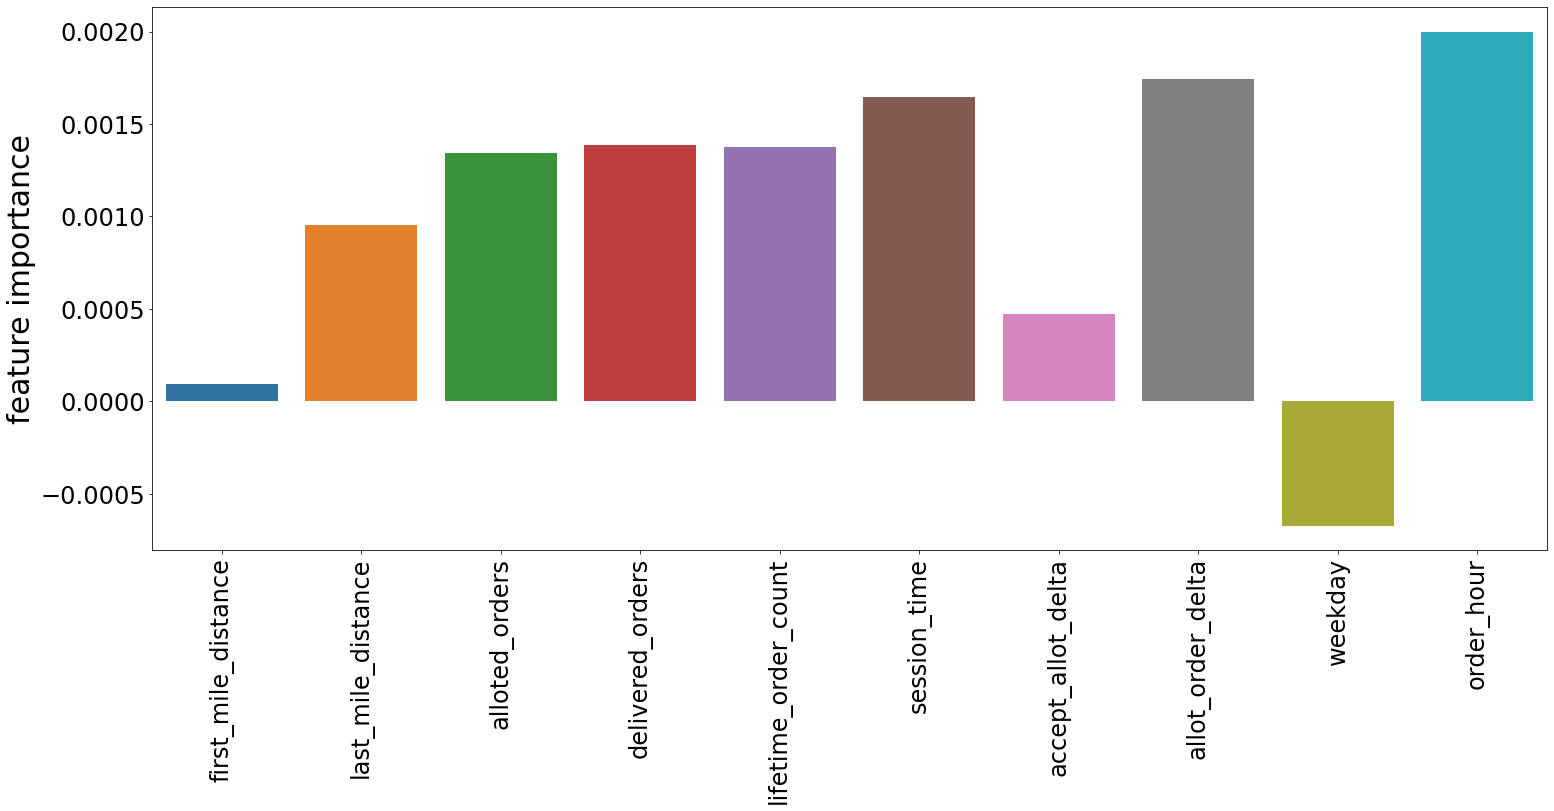

In [ ]:
plt.figure(figsize=(25,10))
sns.barplot(x=list(new_fi.keys()), y=list(new_fi.values()))
plt.xticks(rotation=90, fontsize=24)
plt.yticks(fontsize=24, )
plt.ylabel("feature importance", fontsize=30)
plt.savefig('fig1',transparent=True, bbox_inches='tight')